# Aprendizaje por refuerzos - LAB2 (Final)

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2019

## Alumna: María Lucía Pappaterra

## Ejercicios Lab Final

Se pide:

1) Implementar [Double DQN (DDQN)](https://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/view/12389/11847).

2) Implementar [Dueling DDQN](https://arxiv.org/pdf/1511.06581.pdf).

3) Cambiar el entorno por uno nuevo a elección

4) Implementar [Prioritized Experience Replay (PER)](https://arxiv.org/pdf/1511.05952.pdf) (**Opcional**).

**Comentar en un notebook lo realizado paso a paso, mostrando resultados parciales y finales. Y subirlo a un repositorio en GitHub** 

**Recomendación General**: No se sugiere hacer este TP desde jupyter notebook/lab sino desde un IDE estilo "Pycharm" o "Visual Studio Code", debido a que los algoritmos de RL suelen requerir un debug paso a paso, tanto para corregir errores como para entender mejor cómo funcionan los mismos.

**Opcional**: Implementación de un agente DQN convolucional que aprende a jugar a Atari© Space Invaders© ([link](https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Deep%20Q%20Learning/Space%20Invaders/DQN%20Atari%20Space%20Invaders.ipynb))


Primero Importamos las librerías necesarias:

In [1]:
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

import gym
import random
from collections import deque

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 16, 8
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

from IPython.display import clear_output

### El entorno [CartPole](https://gym.openai.com/envs/CartPole-v1/)

**CartPole**, también conocido como péndulo inverso, es un péndulo con un centro de gravedad sobre su punto de pivote. Es inestable, pero puede controlarse moviendo el punto de pivote debajo del centro de masa. El objetivo es mantener el carro equilibrado mediante la aplicación de fuerzas apropiadas a un punto de pivote.

In [2]:
env = gym.make('CartPole-v0')
env.reset()

array([-0.01792099,  0.02365182, -0.04226258, -0.04006313])

Con el siguiente código representamos la instancia durante 250 pasos, realizando acciones aleatorias.

In [3]:
for _ in range(250):
    env.render(mode='human')
    observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
    if done:
        env.reset()
env.close()
clear_output()
# esto no se puede ejecutar en googlecolabs

El punto violeta indica el punto de pivote.

* El péndulo comienza en posición vertical, y el objetivo es evitar que se caiga.

* Se proporciona una recompensa de +1 por cada paso de tiempo que el poste permanece en posición vertical.

* El episodio termina cuando el poste está a más de 15 grados de la vertical, o el carro se mueve a más de 2.4 unidades del centro.

Comenzamos con un entorno inicial. Todavía no tiene ninguna recompensa asociada, pero tiene un estado ($S_t$).

Luego, para cada iteración, un agente toma el estado actual ($S_t$), elige la mejor acción (basada en la predicción del modelo) ($A_t$) y la ejecuta en un entorno. Posteriormente, el entorno devuelve una recompensa ($R_{t + 1}$) por una acción dada, un nuevo estado ($S_{t + 1}$) y la información de si el nuevo estado es terminal.

El proceso se repite hasta la terminación.

Inicialmente, creamos nuestro entorno y un agente con un espacio de observación (posibles valores de estado) y un espacio de acción (posibles acciones que se pueden realizar)

In [4]:
print(env.observation_space)
print(env.action_space)

Box(4,)
Discrete(2)


#### Observation: 

    Type: Box(4)

| Num | ProbDistribution | Min | Max |
| --- | --- | --- | --- |
| 0 | Cart Position | -4.8 | 4.8 |
| 1 | Cart Velocity | -Inf | Inf |
| 2	| Pole Angle | -24° | 24° |
| 3	| Pole Velocity At Tip | -Inf | Inf |

Las observaciones válidas son arrays de 4 números que indican: la posición del carro, la velocidad del mismo, el ángulo del poste y la velocidad de la punta del poste.

In [5]:
print(env.observation_space.shape)

(4,)


Estas son las cotas de cada campo:

In [6]:
print(env.observation_space.low)
print(env.observation_space.high)

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


#### Action:
    Type: Discrete(2)

| Num Action | |
| --- | --- |
| 0 | Push cart to the left |
| 1 |	Push cart to the right | 

Hay dos acciones posibles, empujar el carro a la izquierda o la derecha.

In [7]:
print(env.action_space.shape)
print(env.action_space.n)

()
2


### Comenzamos

Primero construimos un búfer de reproducción, donde podremos almacenar experiencias (transiciones de estado, acción, recompensa, estado siguiente, bool (is_done)) y ejemplos de experiencias aleatorias para el aprendizaje. Así como una función de entrenamiento por mini batches.

In [8]:
class BasicBuffer:
    
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

        return (state_batch, action_batch, reward_batch, next_state_batch, done_batch)

    def __len__(self):
        return len(self.buffer)

In [9]:
def mini_batch_train(env, agent, max_episodes, max_steps, batch_size):
    episode_rewards = []
    mean_rewards = []

    for episode in range(max_episodes):
        state = env.reset()
        episode_reward = 0 # reward acumulado por episodio
        
        epsilon = agent.epsilon_update(episode)

        for step in range(max_steps):
            action = agent.get_action(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.replay_buffer.push(state, action, reward, next_state, done)
            episode_reward += reward

            if len(agent.replay_buffer) > batch_size:
                batch = agent.replay_buffer.sample(batch_size)
                agent.update(batch)   

            if done or step == max_steps-1:
                episode_rewards.append(episode_reward)
                
                mean_reward = np.mean(episode_rewards) # reward promedio hasta el episodio
                mean_rewards.append(mean_reward)
                
                if episode % 100 == 0:
                    print("Episode " + str(episode) + ":" + " Reward : " + str(episode_reward) + "| Mean Reward : " + str(mean_reward) + "| epsilon :" + str(epsilon))
                break

            state = next_state

    return episode_rewards, mean_rewards 

1. 
### Double DQN

**Double Q Learning** implica el uso de dos estimadores de valor $Q$ separados, cada uno de los cuales se utiliza para actualizar el otro. Este método resuelve el problema de la sobreestimación de los valores $Q$. Pues Usando estos estimadores independientes, podemos estimar sin sesgo el valor $Q$ de las acciones seleccionadas usando el estimador opuesto.

En el caso de **Double Deep QN**, tenemos un modelo $Q$ y un modelo $Q'$ target, en lugar de dos modelos independientes. Utilizamos $Q'$ para la selección de las acciones y $Q$ para la evaluación de las acciones.

Entonces:

   * usamos una red DQN target para seleccionar cuál es la mejor acción para el siguiente estado (la acción con el valor $Q'$ más alto).
   * usamos otra red DQN para calcular el valor $Q*$ esperado de tomar esa acción en el siguiente estado.

In [10]:
class DQN(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_layers=0, num_nodes=128):
        super(DQN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = hidden_layers
        self.num_nodes = num_nodes
               
        hidden_layers = []         
        for i in range(self.num_layers): 
            layer = nn.Linear(self.num_nodes, self.num_nodes) 
            hidden_layers.append(layer) 
            hidden_layers.append(nn.ReLU()) 
                      
        self.fc = nn.Sequential(nn.Linear(input_dim[0], self.num_nodes), 
                                nn.ReLU(),
                                *hidden_layers, 
                                nn.Linear(self.num_nodes, self.output_dim))         
        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)      
        
    def forward(self, state):
        qvals = self.fc(state)
        return qvals

Ahora definimos el **agente**, este debe converger a la política óptima. 

En el mismo, instanciamos tanto un modelo como un modelo target, ya que al computar el loss, usamos a este último para computar el próximo valor de $Q$.

Hiperparámetros: 

* el **learning rate** es el tamaño del paso de actualización del modelo, también se conoce en la literatura como **alpha**
* **tau** indica el paso con el que actualizamos el modelo target 
* **gamma** es la tasa de descuento, debe ser un valor entre 0 y 1 inclusive (valor predeterminado: 1)
* **epsilon** es la probabilidad de elegir una acción aleatoria (este es el mecanismo de exploración del agente). En esta implementación empezaremos con un valor alto de epsilon (0.5), que irá decayendo a medida que pasan los episodios (osea a medida que el agente aprende), hasta alcanzar un epsilon mínimo (0.01).

Utilizamos el optimizador Adam.

In [11]:
class DQNAgent:

    def __init__(self, env, learning_rate=3e-4, model=DQN, gamma=0.99, 
                 epsilon_init=1.0, epsilon_min=0.0001, epsilon_log_decay=0.005, 
                 tau=0.01, buffer_size=10000):
        self.env = env
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon_init = epsilon_init
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.tau = tau
        self.replay_buffer = BasicBuffer(max_size=buffer_size)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # create main model and target model
        self.model = model(env.observation_space.shape, env.action_space.n).to(self.device)
        self.target_model = model(env.observation_space.shape, env.action_space.n).to(self.device)
        
        # hard copy model parameters to target model parameters
        for target_param, param in zip(self.model.parameters(), self.target_model.parameters()):
            target_param.data.copy_(param)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = self.learning_rate)
               
    def get_action(self, state, eps):
            
        if(np.random.random() <= eps):
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).float().unsqueeze(0).to(self.device)
                qvals = self.target_model(state) # model o target_model??
                action = np.argmax(qvals.cpu().detach().numpy())
                return action
    
    def epsilon_update(self, episode):
        return max(self.epsilon_min, self.epsilon_init * math.exp(-self.epsilon_decay * episode))

    def compute_loss(self, batch):     
        states, actions, rewards, next_states, dones = batch
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # resize tensors
        actions = actions.view(actions.size(0), 1)
        dones = dones.view(dones.size(0), 1)

        # compute loss:
        
        # computo los Q de cada estado y me quedo con el Q de la acción que se hace
        curr_Q = self.model(states).gather(1, actions)
        
        # computo los Q para los estados siguientes con la red target
        next_Q = self.target_model(next_states)
        
        # me quedo con las acciones que llevan al mayor valor Q
        max_next_actions = torch.max(next_Q, 1)[1] # en [0] están los valores Q_max, en [1] las acciones    
        max_next_actions = max_next_actions.view(max_next_actions.size(0), 1)
        
        # aplico esas acciones a los estados siguientes desde la red principal 
        max_next_Q = self.model(next_states).gather(1, max_next_actions)
        
        expected_Q = rewards + (1 - dones) * self.gamma * max_next_Q
        
        loss = F.mse_loss(curr_Q, expected_Q.detach())
        
        return loss

    def update(self, batch):

        self.optimizer.zero_grad()
        
        loss = self.compute_loss(batch)
        loss.backward()
        
        #for param in self.model.parameters(): # es necesario poner esto??
        #    param.grad.data.clamp_(-1, 1)
        
        self.optimizer.step()
        
        # target network update
        for target_param, param in zip(self.target_model.parameters(), self.model.parameters()):
            target_param.data.copy_(self.tau * param + (1 - self.tau) * target_param) #Polyak averaging          

Minimizamos el error cuadrático medio entre $Q$ y el $Q*$ esperado, a la vez que actualizamos los valores de $Q'$ target con el promedio de Polyak.

Para calcular el $Q*$ esperado apliqué la siguiente fórmula:

$$ Q*(s_t, a_t) = r_t + \gamma Q(s_{t+1}, argmax_{a'}Q'(s_{t+1}, a_t))$$

*Info sobre qué hace la función [gather](https://stackoverflow.com/questions/50999977/what-does-the-gather-function-do-in-pytorch-in-layman-terms)*

In [12]:
env_id = "CartPole-v0"
MAX_EPISODES = 5000
MAX_STEPS = 500
BATCH_SIZE = 32

env = gym.make(env_id)
agent = DQNAgent(env)
Double_episode_rewards, mean_Double_episode_rewards = mini_batch_train(env, agent, MAX_EPISODES, MAX_STEPS, BATCH_SIZE)

/home/lucia/.anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Episode 0: Reward : 16.0| Mean Reward : 16.0| epsilon :1.0
Episode 100: Reward : 12.0| Mean Reward : 18.99009900990099| epsilon :0.6065306597126334
Episode 200: Reward : 89.0| Mean Reward : 28.228855721393035| epsilon :0.36787944117144233
Episode 300: Reward : 200.0| Mean Reward : 50.96345514950166| epsilon :0.22313016014842982
Episode 400: Reward : 200.0| Mean Reward : 86.356608478803| epsilon :0.1353352832366127
Episode 500: Reward : 16.0| Mean Reward : 98.39920159680639| epsilon :0.0820849986238988
Episode 600: Reward : 9.0| Mean Reward : 89.43427620632279| epsilon :0.049787068367863944
Episode 700: Reward : 200.0| Mean Reward : 101.01141226818831| epsilon :0.0301973834223185
Episode 800: Reward : 200.0| Mean Reward : 113.36953807740325| epsilon :0.01831563888873418
Episode 900: Reward : 200.0| Mean Reward : 122.88901220865705| epsilon :0.011108996538242306
Episode 1000: Reward : 200.0| Mean Reward : 130.5924075924076| epsilon :0.006737946999085467
Episode 1100: Reward : 200.0| Mean

Los rewards son señales numéricas que reflejan qué tan bien se está desempeñando el agente de RL en un entorno determinado. A más recompensa, mejor desempeño. En el caso de CartPole el reward máximo es 200.

A continuación graficamos el reward/score obtenido por episodio.

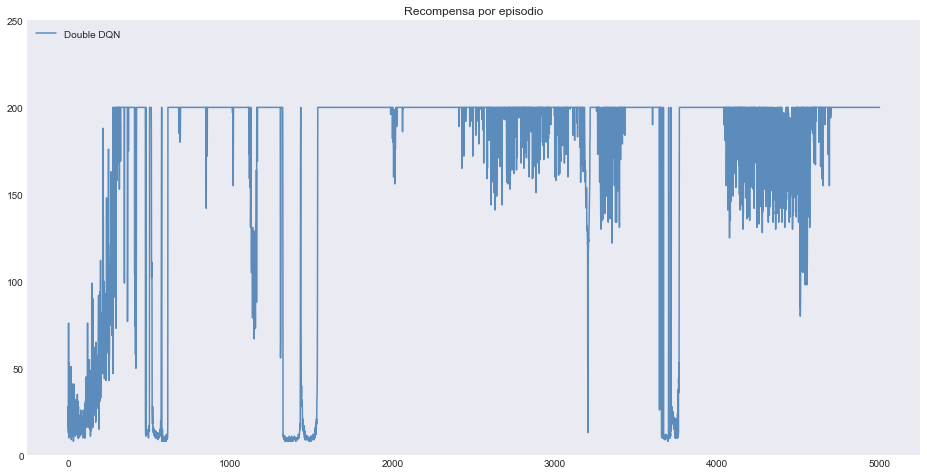

In [21]:
plt.plot(np.array(Double_episode_rewards), label='Double DQN', c='#5c8cbc')
plt.ylim(0, 250)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

El siguiente gráfico es el reward promedio de los rewards acumulados hasta cada episodio.

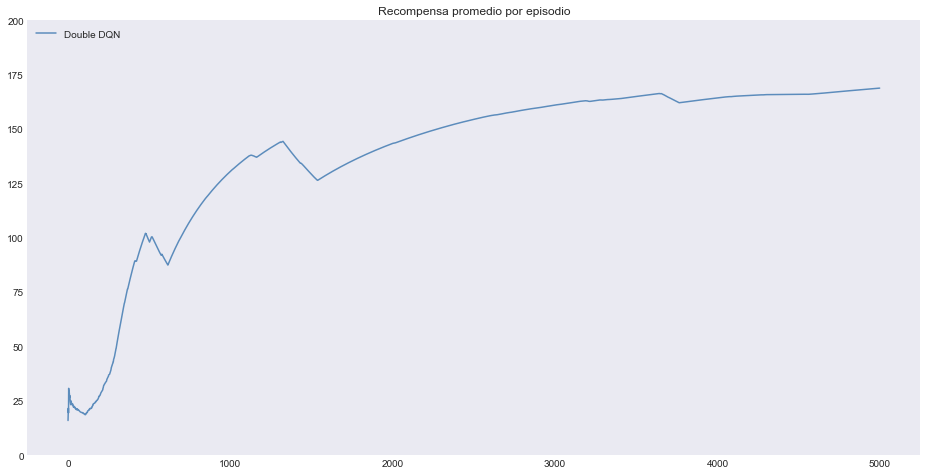

In [22]:
plt.plot(np.array(mean_Double_episode_rewards), label='Double DQN', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

Graficamos el promedio de las recompensas acumuladas ya que los agentes de RL están sujetos a mucha estocasticidad, por eso es que mediante este gráfico buscamos suavizar las curvas, de tal forma que podamos apreciar la tendencia promedio de la recompensa, y que un mal episodio no nos impida ver cosas que sí están mejorando en el agente.

En el último gráfico vemos que la curva crece sostenidamente, indicando que el agente converge hacia la política óptima. Si bien por momentos parece que la convergencia decae o se estanca, esto puede ser culpa de la exploración aleatoria del agente, que genera rewards muy bajos afectando al promedio, como podemos ver en la lista de episodios que imprimimos (por ejemplo se ve que de repente en un episodio muy avanzado se obtiene un reward muy bajo); aunque bien la causa de estos rewards bajos podría ser otra... Sin embargo en el primer gráfico podemos ver que a medida que avanzan los episodios, en la mayoría de los casos se obtiene un reward de 200, lo cual estaría indicando que el agente ha aprendido a jugar correctamente.

Quizás con otros hiperparámetros la convergencia sea mejor, habría que probar...

A continuación muestro los resultados que obtuve utilizando un batch_size de 256. La convergencia fue un poco mejor. Como puede verse en la lista, se alcanzaron valores de recompenza promedio por episodio mayores.

In [1]:
from IPython.display import HTML, display
display(HTML("<table><tr><td><img src='images/batch256.png'></td><td><img src='images/batch256M.png'></td></tr></table>"))

,


![](images/batch256_list.png)

1. 
### Dueling Double DQN

#### Dueling DQN

Recordemos que los valores $Q$ corresponden a lo bueno que es estar en un estado y tomar una acción en ese estado $Q (s, a)$.

Por lo tanto, podemos descomponer a $Q (s, a)$ en una suma de:

   * $V(s)$: el valor de estar en ese estado
   * $A(s,a)$: la ventaja de tomar esa acción en ese estado (cuánto mejor es tomar esta acción en comparación con todas las demás acciones posibles en ese estado)

El objetivo de Dueling DQN es crear una red que compute de manera separada estas funciones de ventaja y valor (advantage and value), y que las reconvine al final, en la última capa, en una sola función $Q$. De esta manera, el agente no tendrá que preocuparse por el valor y la ventaja al mismo momento.

Al desacoplar la estimación, intuitivamente nuestro algoritmo puede aprender qué estados son (o no) valiosos sin tener que aprender el efecto de cada acción en cada estado (ya que también está calculando $V(s)$).

Con el DQN normal, necesitamos calcular el valor de cada acción en cada estado. Pero, ¿qué sentido tiene si el valor del estado es malo? ¿Cuál es el punto de calcular todas las acciones en un estado cuando todas estas acciones conducen a la muerte?

Al desacoplar podemos calcular solo $V(s)$. Esto es particularmente útil para los estados donde sus acciones no afectan el medio ambiente de manera relevante. En este caso, no es necesario calcular el valor de cada acción. Por ejemplo, moverse hacia la derecha o hacia la izquierda solo importa si existe el riesgo de colisión. Y, en la mayoría de los estados, la elección de la acción no tiene efecto sobre lo que sucede.

In [15]:
class DuelingDQN(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_layers=1, num_nodes=128):
        super(DuelingDQN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = hidden_layers
        self.num_nodes = num_nodes
        
        hidden_layers = []         
        for i in range(self.num_layers): 
            layer = nn.Linear(self.num_nodes, self.num_nodes) 
            hidden_layers.append(layer) 
            hidden_layers.append(nn.ReLU())             
        
        self.feauture_layer = nn.Sequential(
            nn.Linear(self.input_dim[0], self.num_nodes),
            nn.ReLU(),
            *hidden_layers
        )

        hidden_layers = []         
        for i in range(self.num_layers): 
            layer = nn.Linear(self.num_nodes, self.num_nodes) 
            hidden_layers.append(layer) 
            hidden_layers.append(nn.ReLU())           
        
        self.value_stream = nn.Sequential(
            *hidden_layers,
            nn.Linear(self.num_nodes, 1)
        )

        hidden_layers = []         
        for i in range(self.num_layers): 
            layer = nn.Linear(self.num_nodes, self.num_nodes) 
            hidden_layers.append(layer) 
            hidden_layers.append(nn.ReLU())   
        
        self.advantage_stream = nn.Sequential(
            *hidden_layers,
            nn.Linear(self.num_nodes, self.output_dim)
        )
        
        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)    

    def forward(self, state):
        features = self.feauture_layer(state)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean())
        
        return qvals

Para implementar **Dueling Double DQN** corremos el agente de Double DQN, con el modelo de red de Dueling anterior.

In [16]:
env_id = "CartPole-v0"
MAX_EPISODES = 5000
MAX_STEPS = 500
BATCH_SIZE = 32

env = gym.make(env_id)
agent = DQNAgent(env, model=DuelingDQN)
Dueling_episode_rewards, mean_Dueling_episode_rewards = mini_batch_train(env, agent, MAX_EPISODES, MAX_STEPS, BATCH_SIZE)

/home/lucia/.anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Episode 0: Reward : 10.0| Mean Reward : 10.0| epsilon :1.0
Episode 100: Reward : 36.0| Mean Reward : 49.46534653465346| epsilon :0.6065306597126334
Episode 200: Reward : 112.0| Mean Reward : 89.60696517412936| epsilon :0.36787944117144233
Episode 300: Reward : 159.0| Mean Reward : 115.89368770764119| epsilon :0.22313016014842982
Episode 400: Reward : 200.0| Mean Reward : 123.6284289276808| epsilon :0.1353352832366127
Episode 500: Reward : 11.0| Mean Reward : 109.98003992015968| epsilon :0.0820849986238988
Episode 600: Reward : 187.0| Mean Reward : 99.9351081530782| epsilon :0.049787068367863944
Episode 700: Reward : 99.0| Mean Reward : 107.11412268188302| epsilon :0.0301973834223185
Episode 800: Reward : 200.0| Mean Reward : 117.57303370786516| epsilon :0.01831563888873418
Episode 900: Reward : 10.0| Mean Reward : 122.87902330743619| epsilon :0.011108996538242306
Episode 1000: Reward : 200.0| Mean Reward : 116.92807192807193| epsilon :0.006737946999085467
Episode 1100: Reward : 111.0| 

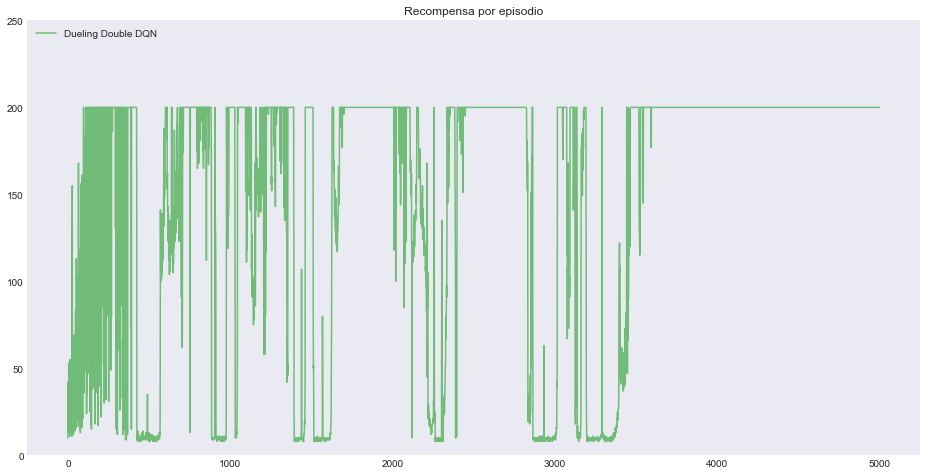

In [19]:
plt.plot(np.array(Dueling_episode_rewards), label='Dueling Double DQN', c='#71bc78')
plt.ylim(0, 250)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

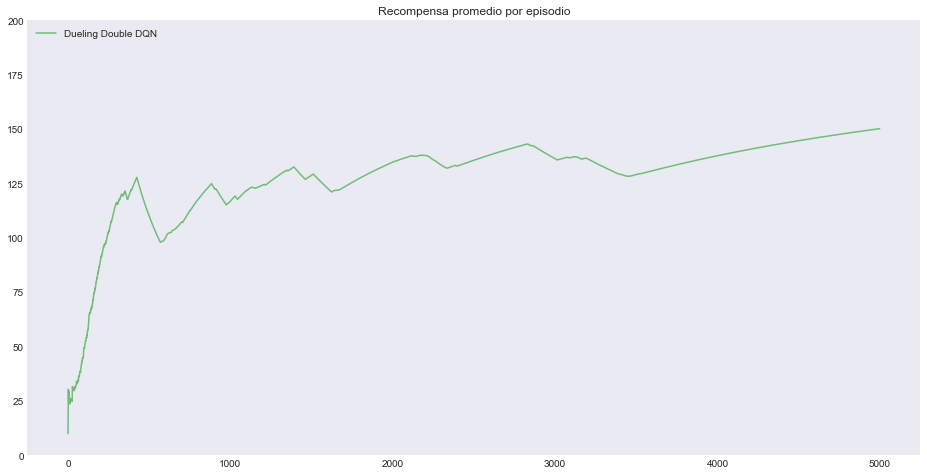

In [20]:
plt.plot(np.array(mean_Dueling_episode_rewards), label='Dueling Double DQN', c='#71bc78')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

### Comparación de los resultados:

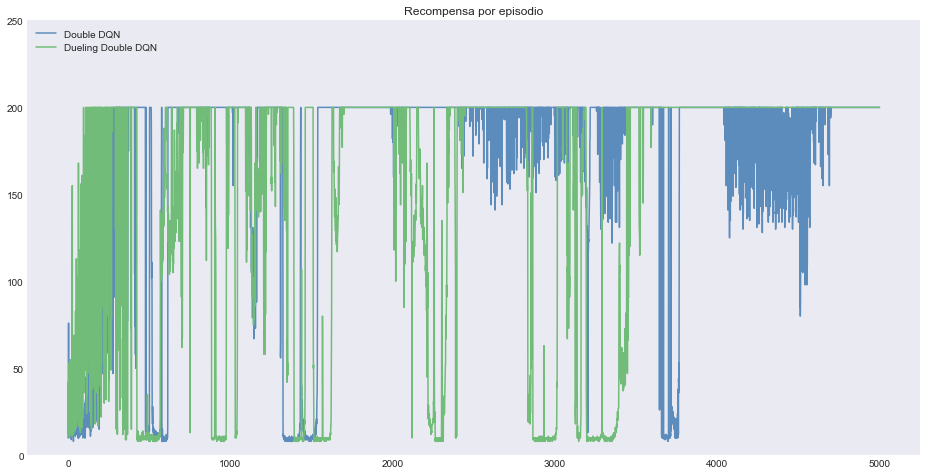

In [23]:
plt.plot(np.array(Double_episode_rewards), label='Double DQN', c='#5c8cbc')
plt.plot(np.array(Dueling_episode_rewards), label='Dueling Double DQN', c='#71bc78')
plt.ylim(0, 250)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

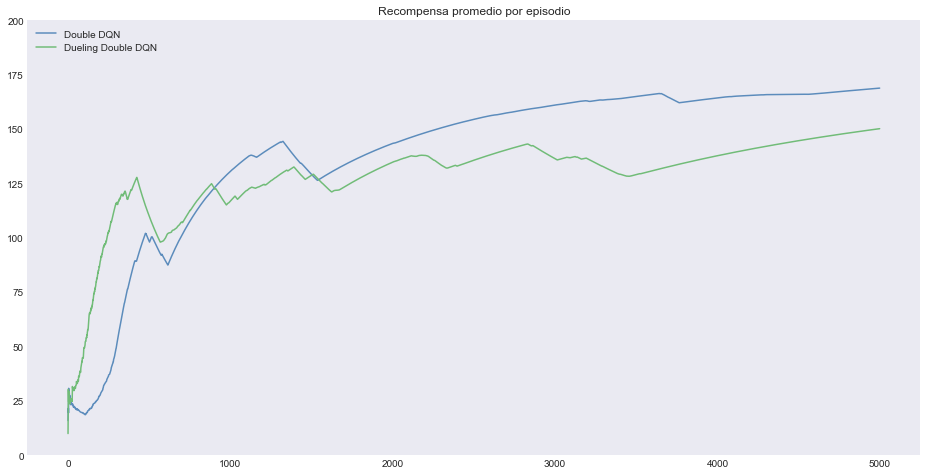

In [24]:
plt.plot(np.array(mean_Double_episode_rewards), label='Double DQN', c='#5c8cbc')
plt.plot(np.array(mean_Dueling_episode_rewards), label='Dueling Double DQN', c='#71bc78')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

Vemos que al principio converge mejor Dueling DDQN, pero luego Double DQN lo supera.

Si bien en este último grafico podemos ver que Double DQN alcanza valores de rewards promedio más altos que Dueling DDQN, en el gráfico anterior se ve que Dueling DDQN tiene menos 'recaidas' en valores de reward muy bajos hacia el final de los episodios (a partir del episodio 3700 aproximadamente, todos los rewards son igual a 200), mientras que Double DQN tiene más 'recaidas' en episodios avanzados.

3. ### El entorno [Acrobot](https://gym.openai.com/envs/Acrobot-v1/)

El sistema **Acrobot** incluye dos articulaciones y dos enlaces, donde se acciona la unión entre los dos enlaces. Inicialmente, los enlaces están colgando hacia abajo, y el objetivo es balancear el extremo del enlace inferior hasta una altura determinada.

In [27]:
env = gym.make('Acrobot-v1')
env.reset()

array([ 0.99997946, -0.00640972,  0.99998465,  0.00554104,  0.06866506,
        0.0373439 ])

In [28]:
for _ in range(200):
    env.render(mode='human')
    observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
    if done:
        env.reset()
env.close()
clear_output()

In [29]:
print(env.observation_space)
print(env.action_space)

Box(6,)
Discrete(3)


In [30]:
print(env.observation_space.shape)

(6,)


In [31]:
print(env.observation_space.low)
print(env.observation_space.high)

[ -1.        -1.        -1.        -1.       -12.566371 -28.274334]
[ 1.        1.        1.        1.       12.566371 28.274334]


In [32]:
print(env.action_space.shape)
print(env.action_space.n)

()
3


#### Double DQN

In [33]:
env_id = 'Acrobot-v1'
MAX_EPISODES = 5000
MAX_STEPS = 500
BATCH_SIZE = 32

env = gym.make(env_id)
agent = DQNAgent(env)
Double_episode_rewards, mean_Double_episode_rewards = mini_batch_train(env, agent, MAX_EPISODES, MAX_STEPS, BATCH_SIZE)

/home/lucia/.anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Episode 0: Reward : -500.0| Mean Reward : -500.0| epsilon :1.0
Episode 100: Reward : -238.0| Mean Reward : -359.34653465346537| epsilon :0.6065306597126334
Episode 200: Reward : -103.0| Mean Reward : -259.771144278607| epsilon :0.36787944117144233
Episode 300: Reward : -84.0| Mean Reward : -210.9202657807309| epsilon :0.22313016014842982
Episode 400: Reward : -111.0| Mean Reward : -183.5586034912718| epsilon :0.1353352832366127
Episode 500: Reward : -84.0| Mean Reward : -167.4011976047904| epsilon :0.0820849986238988
Episode 600: Reward : -117.0| Mean Reward : -155.23960066555742| epsilon :0.049787068367863944
Episode 700: Reward : -82.0| Mean Reward : -146.03566333808845| epsilon :0.0301973834223185
Episode 800: Reward : -70.0| Mean Reward : -138.96629213483146| epsilon :0.01831563888873418
Episode 900: Reward : -100.0| Mean Reward : -133.503884572697| epsilon :0.011108996538242306
Episode 1000: Reward : -100.0| Mean Reward : -128.9010989010989| epsilon :0.006737946999085467
Episode 1

En muchos entornos, como por ejemplo Acrobot o MountainCar, el agente es motivado con "castigos" constantes para penalizarlo cuando tarda más tiempo (y, de paso, motivar la exploración del espacio de estados). Puede ser pensado como que cada recompensa de -1 corresponde a una penalización por cada 1 paso de tiempo. Es por esto que se obtienen rewards negativos.

#### Dueling Double DQN

In [34]:
env_id = 'Acrobot-v1'
MAX_EPISODES = 5000
MAX_STEPS = 500
BATCH_SIZE = 32

env = gym.make(env_id)
agent = DQNAgent(env, model=DuelingDQN)
Dueling_episode_rewards, mean_Dueling_episode_rewards = mini_batch_train(env, agent, MAX_EPISODES, MAX_STEPS, BATCH_SIZE)

/home/lucia/.anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Episode 0: Reward : -500.0| Mean Reward : -500.0| epsilon :1.0
Episode 100: Reward : -219.0| Mean Reward : -345.41584158415844| epsilon :0.6065306597126334
Episode 200: Reward : -112.0| Mean Reward : -250.76119402985074| epsilon :0.36787944117144233
Episode 300: Reward : -85.0| Mean Reward : -206.00996677740864| epsilon :0.22313016014842982
Episode 400: Reward : -85.0| Mean Reward : -179.40648379052368| epsilon :0.1353352832366127
Episode 500: Reward : -62.0| Mean Reward : -162.49700598802394| epsilon :0.0820849986238988
Episode 600: Reward : -78.0| Mean Reward : -149.88352745424294| epsilon :0.049787068367863944
Episode 700: Reward : -136.0| Mean Reward : -140.22824536376604| epsilon :0.0301973834223185
Episode 800: Reward : -96.0| Mean Reward : -133.49188514357053| epsilon :0.01831563888873418
Episode 900: Reward : -74.0| Mean Reward : -126.99889012208656| epsilon :0.011108996538242306
Episode 1000: Reward : -86.0| Mean Reward : -121.84415584415585| epsilon :0.006737946999085467
Epis

#### Visualización de resultados

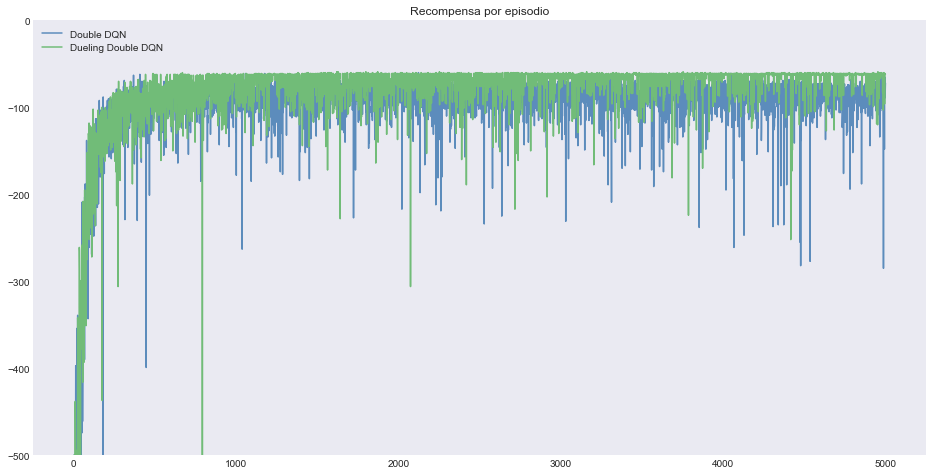

In [37]:
plt.plot(np.array(Double_episode_rewards), label='Double DQN', c='#5c8cbc')
plt.plot(np.array(Dueling_episode_rewards), label='Dueling Double DQN', c='#71bc78')
plt.ylim(-500, 0)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

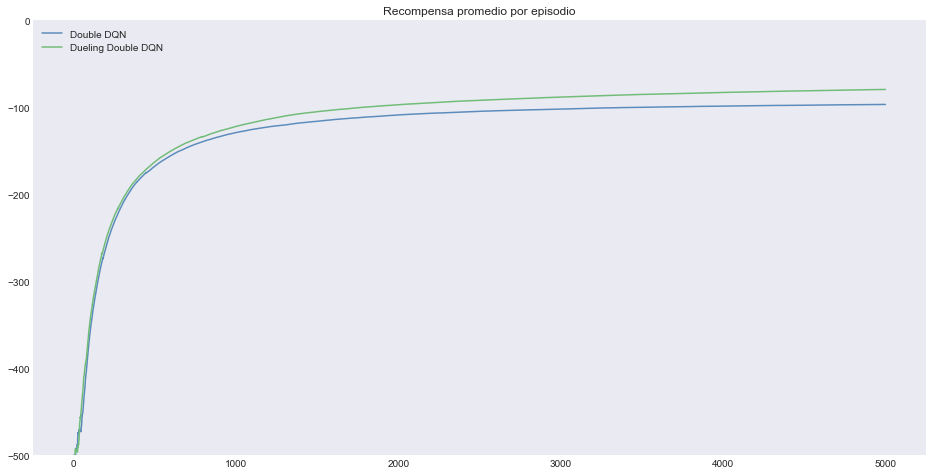

In [38]:
plt.plot(np.array(mean_Double_episode_rewards), label='Double DQN', c='#5c8cbc')
plt.plot(np.array(mean_Dueling_episode_rewards), label='Dueling Double DQN', c='#71bc78')
plt.ylim(-500, 0)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

Para este juego converge mejor Dueling DQN, aunque ambos algoritmos andan muy bien.